In [1]:
%load_ext autoreload
%autoreload 2

import poisson_atac as patac
import scanpy as sc

import scipy.sparse
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
import torch

Global seed set to 0


In [2]:
import scvi
scvi.__version__

'0.0.0'

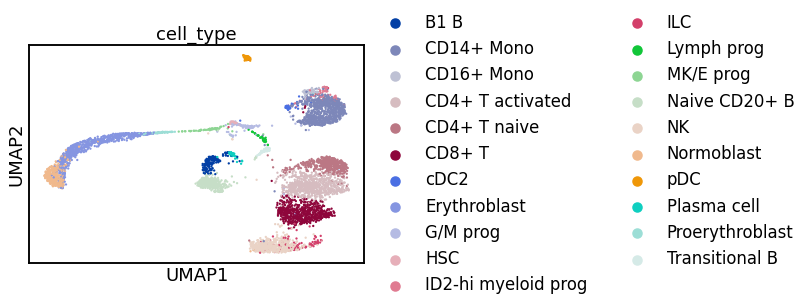

In [3]:
adata = patac.data.load_neurips(gex=True, batch='s1d1')

sc.pl.umap(adata, color = "cell_type")

# Run scvi on "corrected" ATAC with poisson loss

In [4]:
#import scvi

#adata = adata[adata.obs.batch == 's1d1'].copy()

adata.layers["counts"].max()

94.0

In [5]:
def compute_embedding(adata, X_emb):      
    adata.obsm['X_emb'] = X_emb
    
    if 'X_umap' in adata.obsm.keys():
        adata.obsm.pop('X_umap')
    if 'umap' in adata.obsm.keys():
        adata.obsm.pop('umap')  
    if 'neighbors' in adata.uns.keys():
        adata.uns.pop('neighbors')
    sc.pp.neighbors(adata, use_rep='X_emb')
    sc.tl.umap(adata)

# SCVI

In [21]:
scvi.model.SCVI.setup_anndata(adata, layer="counts")

NameError: name 'scvi' is not defined

In [6]:
model = scvi.model.SCVI(adata=adata, gene_likelihood="poisson", n_latent=18, n_hidden=341, use_layer_norm="both", use_batch_norm="none")

In [7]:
model.module

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=18, bias=True)
    (var_encoder): Linear(in_features=341, out_features=18, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=1, bias=True)
    (var_encoder): Linear(in_features=341, out_feat

In [8]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger, early_stopping=True, early_stopping_monitor="reconstruction_loss_validation")
wandb.finish()

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: lauradm (use `wandb login --relogin` to force relogin)
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 3/400:   0%|          | 2/400 [00:16<47:09,  7.11s/it, loss=1.23e+04, v_num=v214]  

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:58: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


elbo_train,█▁
elbo_validation,█▁
epoch,▁▁▁▁▁▁▅▅▅▅▅▅█
kl_global_train,▁▁
kl_global_validation,▁▁
kl_local_train,▁█
kl_local_validation,█▁
reconstruction_loss_train,█▁
reconstruction_loss_validation,█▁
train_loss_epoch,█▁
train_loss_step,█▆▇█▆▆▄▃▁


In [ ]:
pip install wandb

In [ ]:
X_emb = model.get_latent_representation(atac)

In [ ]:
compute_embedding(atac, X_emb)

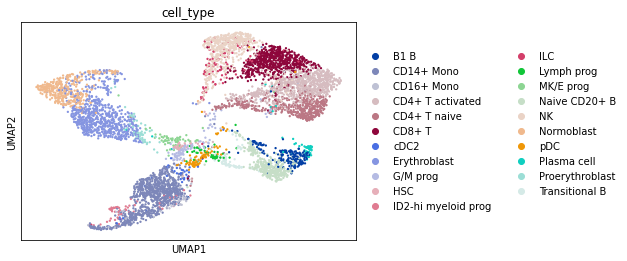

In [ ]:
sc.pl.umap(atac, color = ["cell_type"])

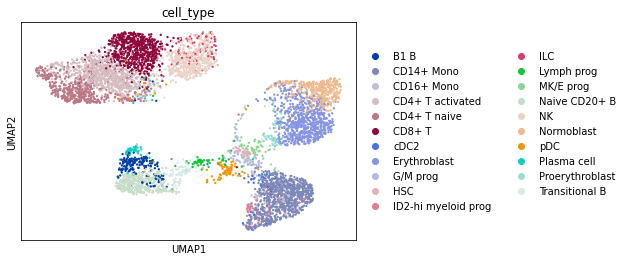

In [27]:
sc.pl.umap(atac, color = ["cell_type"])

In [43]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_scvi_halved")

# amtortized LDA

In [10]:
scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")

In [11]:
model = scvi.model.AmortizedLDA(adata, n_topics=130)

In [12]:
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')
#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True)
wandb.finish()

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: lauradm (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 74/1000:   7%|▋         | 73/1000 [10:17<2:10:20,  8.44s/it, v_num=m2e8, elbo_train=1.87e+8]

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:58: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


elbo_train,▇█▇▇▅▆▅▅▅▄▃▃▃▂▃▂▃▂▂▁▂▂▂▂▁▂▁▂▂▁▁▂▁▂▂▂▂▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
elbo_train,186645184.0
epoch,72
trainer/global_step,2627


In [14]:
X_emb = model.get_latent_representation(adata)

In [15]:
compute_embedding(adata, X_emb)

Epoch 19/1000:   2%|▏         | 18/1000 [15:43<14:18:19, 52.44s/it, v_num=1, elbo_train=2.16e+8]


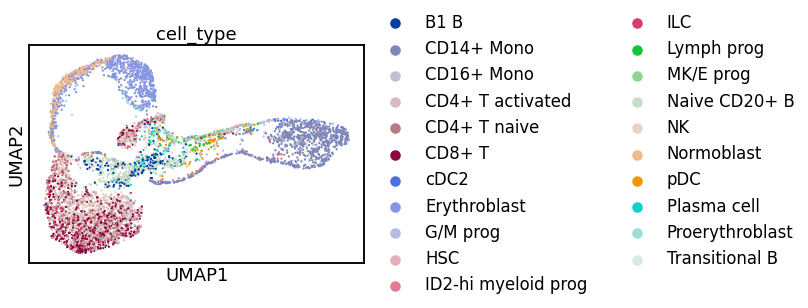

In [16]:
sc.pl.umap(adata, color = ["cell_type"])

# PEAKVI

In [54]:
atac = adata[adata.obs.batch == 's1d1'].copy()

In [55]:
atac.layers["counts"].data = np.ceil(atac.layers["counts"].data/2)

In [56]:
atac.layers["counts"].max()

94.0

In [57]:
scvi.model.PEAKVI.setup_anndata(atac)

/storage/groups/ml01/code/laura.martens/github_repos/scvi-tools/scvi/data/anndata/_utils.py:97: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [60]:
model = scvi.model.PEAKVI(adata=atac)

In [62]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True)
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 122/500:  24%|██▍       | 122/500 [20:58<1:04:58, 10.31s/it, loss=1.55e+08, v_num=zrss]


elbo_train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
elbo_validation,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_global_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_global_validation,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_local_train,▁▅▆▆▅▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
kl_local_validation,▁▄▆▆▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
reconstruction_loss_train,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss_validation,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▇▁▆▇▇▆▆▆▆▆▆▆▆▆▁▆▆▆▆▆▆▆▆▆▆▆▆▁▆▆▆▆▆▆▆▆▆▆


In [63]:
X_emb = model.get_latent_representation(atac)

In [64]:
compute_embedding(atac, X_emb)

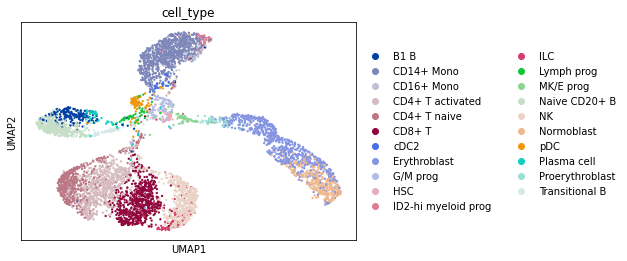

In [65]:
sc.pl.umap(atac, color = ["cell_type"])

# Own model

In [24]:
from poisson_atac.seml import evaluation_table, evaluate_embedding, evaluate_test_cells

In [27]:
patac.model.GEXtoATAC.setup_anndata(adata, layer="counts", batch_key="batch", adata_gex_obsm_key="X_gex")
#patac.model.LinearCountPEAKVI.setup_anndata(adata, layer="counts", batch_key="batch")

INFO     Generating sequential column names                                                  


In [50]:
#model = patac.model.PEAKVI(adata, n_latent=130)
#model = patac.model.GEXtoATAC(adata, n_layers_decoder=0, n_latent=136, use_layer_norm="encoder", n_hidden=150)
model = patac.model.GEXtoATAC(adata, n_latent=136, use_layer_norm="encoder", n_hidden=150)
#model = patac.model.LinearCountPEAKVI(adata, n_latent=130, use_layer_norm="encoder")

13431


In [51]:
model.module

GEXTOATACVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13431, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=150, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=150, out_features=136, bias=True)
    (var_encoder): Linear(in_features=150, out_features=136, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features

In [38]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')
#
#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True, batch_size=128, max_epochs =500, lr = 5e-4)
wandb.finish()

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 81/500:  16%|█▌        | 81/500 [10:27<54:03,  7.74s/it, loss=1.74e+08, v_num=hkju]  


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:58: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


elbo_train,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
elbo_validation,█▄▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
kl_global_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_global_validation,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_local_train,▁▄▄▅▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
kl_local_validation,▁▃▄▄▄▃▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
reconstruction_loss_train,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss_validation,█▄▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
train_loss_epoch,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,███▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▁


In [39]:
X_emb = model.get_latent_representation()

In [40]:
compute_embedding(adata, X_emb)

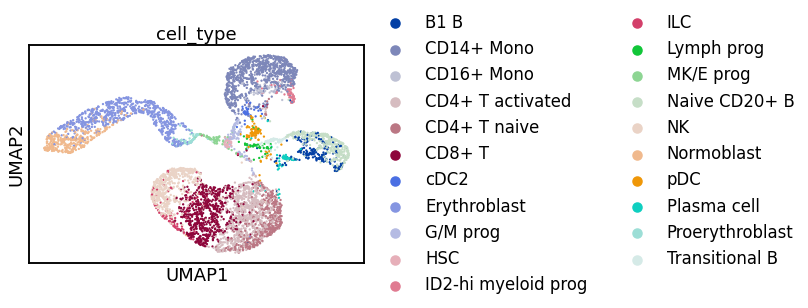

In [41]:
sc.pl.umap(adata, color = ["cell_type"])

In [42]:
evaluate_embedding(adata, X_emb, labels_key = "cell_type")

NMI...
ARI...


,0
NMI_cluster/label,0.736945
ARI_cluster/label,0.577933
ASW_label,NaN
ASW_label/batch,NaN
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN


In [43]:
5+6

11

In [17]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count_gex")

In [23]:
evaluate_test_cells(model, adata)

,Model
auroc,0.900286
average_precision,0.283624
bce,10648.557829
rmse,0.153431


In [45]:
evaluate_test_cells(model, adata)

,Model
auroc,0.899580
average_precision,0.283068
bce,10659.690391
rmse,0.153462


# Check seml

In [5]:
patac.seml.experiment_runner_atac_to_atac.ExprimentWrapper()

AttributeError: module 'poisson_atac.seml' has no attribute 'experiment_runner_atac_to_atac'

In [12]:
patac.model.PEAKVI.setup_anndata(atac, layer="counts")

In [14]:
model =  patac.model.PEAKVI.load( "/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count", adata=atac)

In [32]:
X_emb = model.get_latent_representation(atac)

In [20]:
compute_embedding(adata, X_emb)

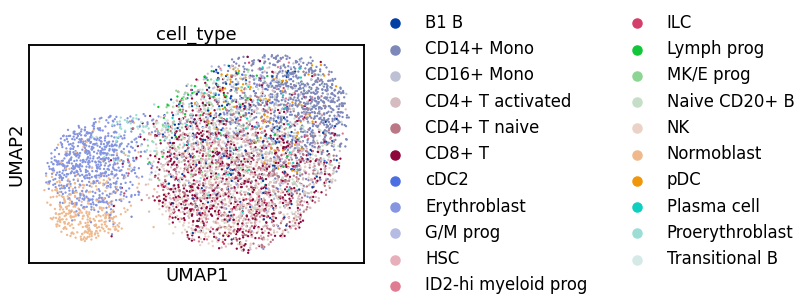

In [22]:
sc.pl.umap(adata, color = ["cell_type"])

In [22]:
model.module

CountVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=130, bias=True)
    (var_encoder): Linear(in_features=341, out_features=130, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13